In [2]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import math

from folium.plugins import HeatMap
import folium

plt.style.use('seaborn')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data

## Loading data

In [2]:
#this CSV file contains data for 2010 to 2015
data = pd.read_csv('data-2010-2015.csv')

In [3]:
data.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [4]:
data.head()

ID Case Number                 Date                     Block  IUCR  \
0  11227517    JB138481  2013-02-10 00:00:00     071XX S LAFAYETTE AVE  0266   
1  11227503    JB146383  2015-01-01 00:01:00      061XX S KILBOURN AVE  1751   
2  11227247    JB147078  2012-01-01 09:00:00  105XX S INDIANAPOLIS AVE  1153   
3  11028056    JA359834  2014-10-15 15:00:00        047XX S PULASKI RD  1153   
4  11028299    JA360073  2015-05-30 00:00:00       074XX S HARVARD AVE  1753   

                 Primary Type                          Description  \
0         CRIM SEXUAL ASSAULT                            PREDATORY   
1  OFFENSE INVOLVING CHILDREN         CRIM SEX ABUSE BY FAM MEMBER   
2          DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
3          DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
4  OFFENSE INVOLVING CHILDREN        SEX ASSLT OF CHILD BY FAM MBR   

             Location Description  Arrest  Domestic  ...  Ward  \
0                       RESIDENCE   False     False  ...   6.0   
1                       RESIDENCE   False      True  ...  13.0   
2                       RESIDENCE   False     False  ...  10.0   
3  PARKING LOT/GARAGE(NON.RESID.)   False     False  ...  14.0   
4                       RESIDENCE   False      True  ...  17.0   

   Community Area  FBI Code  X Coordinate Y Coordinate  Year  \
0            69.0        02           NaN          NaN  2013   
1            65.0        17           NaN          NaN  2015   
2            52.0        11           NaN          NaN  2012   
3            57.0        11           NaN          NaN  2014   
4            69.0        02           NaN          NaN  2015   

               Updated On  Latitude Longitude  Location  
0  02/11/2018 03:57:41 PM       NaN       NaN       NaN  
1  04/12/2019 04:00:15 PM       NaN       NaN       NaN  
2  02/11/2018 03:57:41 PM       NaN       NaN       NaN  
3  07/24/2017 03:54:23 PM       NaN       NaN       NaN  
4  05/15/2018 03:52:47 PM       NaN       NaN       NaN  

[5 rows x 22 columns]

In [5]:
data.shape

(1905255, 22)

We have around 1.9 million rows and 22 columns.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905255 entries, 0 to 1905254
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 294.4+ MB


## Removing null rows

In [7]:
#counting number of rows with null values
np.count_nonzero(data.isnull())

54910

54910 rows out of around 1.9M (~2.88%) rows have null values. We'll remove these

In [8]:
data.dropna(how='any', axis=0, inplace=True) 

In [9]:
np.count_nonzero(data.isnull())

0

All rows with null values are dropped

## Exploring columns and Data cleaning

1. <b>ID:</b> Unique identifier for the record
2. <b>Case Number:</b> The Chicago Police Department RD Number (Records Division Number), which is unique to the incident
3. <b>Date:</b> Date when the incident occurred, this is sometimes a best estimate. Date format example: 2014-10-13T00:00:00.000 Date has no timezone information and encoded as ISO8601 times
4. <b>Block:</b> The partially redacted address where the incident occurred, placing it on the same block as the actual address
5. <b>IUCR:</b> The Illinois Unifrom Crime Reporting code. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e. There are around 400 IUCR codes used by state of Illiois
6. <b>Primary type:</b> The primary description of the IUCR code
7. <b>Description:</b> The secondary description of the IUCR code, a subcategory of the primary description
8. <b>Location Description:</b> Description of the location where the incident occurred
9. <b>Arrest:</b> Indicates whether an arrest was made. Boolean value
10. <b>Domestic:</b> Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act. Boolean value
11. <b>Beat:</b> Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
12. <b>District:</b> Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
13. <b>Ward:</b> The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
14. <b>Community area:</b> Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
15. <b>FBI Code:</b> Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
16. <b>X Coordinate:</b> The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
17. <b>Y Coordinate:</b> The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
18. <b>Year:</b> Year the incident occurred.
19. <b>Updated On:</b> Date and time the record was last updated.
20. <b>Latitude:</b> The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
21. <b>Longitude:</b> The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
22. <b>Location:</b> The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block. Location is a type that contains latitude, longitude and address. 
    - The latitude of the location. This may be null, if the object has been recently uploaded. This must be decimal degrees, for example: 41.8657007325722
    - The longitude of the location. This may be null, if the object has been recently uploaded. This must be in decimal degrees, for example: -87.76110202195098
    - A JSON object containing the U.S. address. This may be null. The object has the following members:
        - address – The street address of the location.
        - city – The city this address is in
        - state – The state this address is in
        - zip – The zip code for this address

Source: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

There are <b>geographical columns</b> which tells us when and where the crime took place. And there are <b>crime-type columns</b> which tells us what kind of crime took place

In [10]:
#exploring location column
data['Location']

9907       (41.781100462, -87.765509056)
9908        (41.924133516, -87.75437255)
9912       (41.823281439, -87.684887848)
9917       (41.843916158, -87.706240919)
9920        (41.877565108, -87.68479102)
9924       (41.876632378, -87.649829352)
9925       (41.769497284, -87.684597656)
9935       (41.782467577, -87.657125736)
9942       (41.761532405, -87.710720019)
9950       (41.793415261, -87.651212934)
9951       (41.844074267, -87.628442088)
9954        (41.83190425, -87.620565482)
9956        (41.877452438, -87.69455585)
9966       (41.858884176, -87.654728116)
9971        (41.733656288, -87.64354723)
9973        (41.697823571, -87.62325266)
9974       (41.816039143, -87.626258734)
9979       (41.920789089, -87.768303152)
9980       (41.893946016, -87.637527948)
9981       (41.997254246, -87.660477873)
9983         (41.995376421, -87.7154944)
9987       (41.779054042, -87.697560782)
9988       (41.802460754, -87.652657418)
9991        (41.79029071, -87.767096428)
9994        (41.

This column contains Latitue, Longitude pair only. As we already have that informaton, we can drop this column

In [11]:
data.drop(['Location'], axis=1, inplace=True)

<b>Exploring Latitude and Longitude</b> <br>
Chicago is bounded by box: 41.6439,-87.9401; 41.9437,-87.5878 <br>
Source: https://boundingbox.klokantech.com/

In [12]:
#Exploring Latitude and Longitude
#we'll remove all rows outside of this range

print('Current rows:', data.shape[0])
data = data[(((data.Latitude >= 41.64) & (data.Longitude <= -87.50)) | 
            ((data.Latitude <= 41.94) & (data.Longitude >= -87.94)))]
print('Rows after removing out of box points:', data.shape[0])

Current rows: 1893389
Rows after removing out of box points: 1893314


This shows that there is few errors in lat,long columns. Now All points are inside the bouding box of Chicago

In [13]:
#X-coord and Y-coord
data[['X Coordinate', 'Y Coordinate']].describe()

X Coordinate  Y Coordinate
count  1.893314e+06  1.893314e+06
mean   1.164458e+06  1.885381e+06
std    1.637121e+04  3.143207e+04
min    1.092706e+06  1.813894e+06
25%    1.152621e+06  1.858647e+06
50%    1.165910e+06  1.890546e+06
75%    1.176352e+06  1.909003e+06
max    1.205119e+06  1.951573e+06

In [14]:
print('Current rows:', data.shape[0])
data[['X Coordinate', 'Y Coordinate']] = data[['X Coordinate', 'Y Coordinate']].replace(0.0, np.nan)
data.dropna(inplace=True)

Current rows: 1893314


In [15]:
print('Rows after removing errorneous coords:', data.shape[0])

Rows after removing errorneous coords: 1893314


In [16]:
#Updated On column
#We don't need this
data.drop(['Updated On'], axis=1, inplace=True)

In [17]:
#Date column represents the date of crime
print('Range of dates: {} to {}'.format(data.Date.min(), data.Date.max()))

Range of dates: 2010-01-01 00:00:00 to 2015-12-31 23:59:00


In [18]:
#year column represents the year of crime
print('Range of year: {} to {}'.format(data.Year.min(), data.Year.max()))

Range of year: 2010 to 2015


Now for each row we'll check if year in Date column matches year in Year column

In [19]:
#creating datetime index
data.index = pd.DatetimeIndex(data.Date)

In [20]:
#removing rows with mismatch in year
print('Current rows:', data.shape[0])
data = data[data.index.year == data.Year]
print('Rows after removing mismatch:', data.shape[0])

Current rows: 1893314
Rows after removing mismatch: 1893314


In [21]:
#we'll create some new columns like month, dayOfWeek, dayOfMonth, weekOfMonth(wom)
data['Month'] = data.index.month
data['dayOfWeek'] = data.index.dayofweek
data['dayOfMonth'] = data.index.day
data['dayOfYear'] = data.index.dayofyear
data['weekOfMonth'] = data.dayOfMonth.apply(lambda d: (d - 1) // 7 + 1)

dayOfYear = list(data.index.dayofyear)

weekOfYear = [math.ceil(i/7) for i in dayOfYear]
data['weekOfYear'] = weekOfYear

In [22]:
#de-duplication of data
print('Current rows:', data.shape[0])
data.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
print('Rows after deduplication:', data.shape[0])

Current rows: 1893314
Rows after deduplication: 1893314


In [23]:
#We don't need unique identifiers like ID and Case Number
data.drop(['ID', 'Case Number'], axis=1, inplace=True)

In [24]:
#Arrest Column
data.Arrest.value_counts()

False    1373043
True      520271
Name: Arrest, dtype: int64

In [25]:
data.Arrest = data.Arrest.astype(int)

In [26]:
data.Arrest.value_counts()

0    1373043
1     520271
Name: Arrest, dtype: int64

In [27]:
#Domestic Column
data.Domestic.value_counts()

False    1617050
True      276264
Name: Domestic, dtype: int64

In [28]:
data.Domestic = data.Domestic.astype(int)

In [29]:
data.Domestic.value_counts()

0    1617050
1     276264
Name: Domestic, dtype: int64

## Exploratory data analysis (EDA)

Credits:
- https://www.kaggle.com/fahd09/eda-of-crime-in-chicago-2005-2016
- https://python-visualization.github.io/folium/quickstart.html#Getting-Started
- https://medium.com/@ahsanzafar222/chicago-crime-data-cleaning-and-eda-a744c687a291
- https://www.kaggle.com/skeftical/chicago-crimes-eda-spatio-temporal

### Day of Week

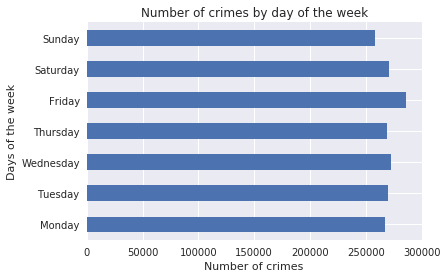

In [30]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data.groupby([data.dayOfWeek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

In [31]:
data.dayOfWeek.value_counts(normalize=True)

4    0.150856
2    0.143849
5    0.142921
1    0.142451
3    0.142292
0    0.141080
6    0.136552
Name: dayOfWeek, dtype: float64

Most crimes happen on a Friday, but there is no considerable difference between the number of crimes happening on a particular day.

### Month

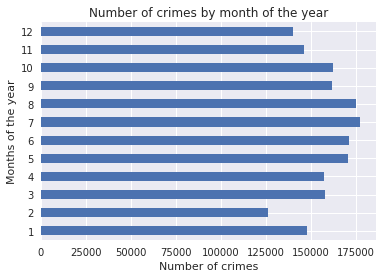

In [32]:
data.groupby([data.Month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

In [33]:
data.Month.value_counts(normalize=True)

7     0.093572
8     0.092475
6     0.090372
5     0.090216
10    0.085583
9     0.085473
3     0.083304
4     0.083082
1     0.078030
11    0.077294
12    0.073897
2     0.066702
Name: Month, dtype: float64

1. Again there is no considerable difference between the crimes happening in a particular month 
2. <b>February has lowest number of crimes occured </b>
3. One reason of this can be less number of days in month of February

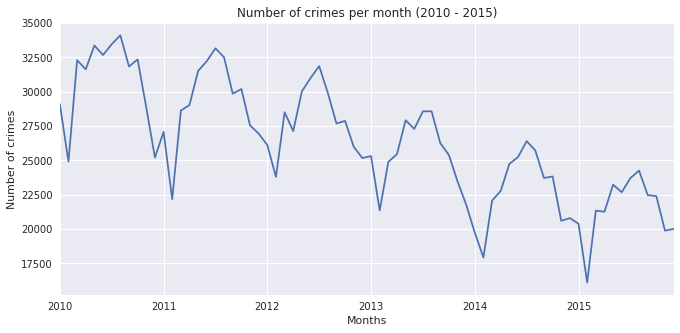

In [34]:
plt.figure(figsize=(11,5))
data.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2010 - 2015)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

We see a trend here. Every year, crime rates first increase by month and than starts to decrease. Maybe due to these trends, fourier features can be of use. Overall crimes rate have a downward trend

### Day of Month

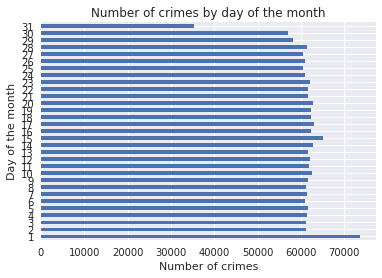

In [35]:
data.groupby([data.dayOfMonth]).size().plot(kind='barh')
plt.ylabel('Day of the month')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the month')
plt.show()

In [36]:
data.dayOfMonth.value_counts(normalize=True)

1     0.038870
15    0.034414
17    0.033260
20    0.033135
14    0.033124
10    0.033085
18    0.032978
16    0.032944
19    0.032927
23    0.032858
12    0.032858
11    0.032663
21    0.032574
5     0.032560
9     0.032536
13    0.032510
22    0.032496
4     0.032436
7     0.032423
28    0.032400
8     0.032369
2     0.032314
3     0.032283
6     0.032199
24    0.032183
26    0.032164
27    0.031973
25    0.031945
29    0.030701
30    0.030133
31    0.018687
Name: dayOfMonth, dtype: float64

1. Again, day of the month does not show any considerable variations
2. Acc. to the graph we can see that 1st day of the month records highest crime, but when looking at the percentages, it's not a lot of difference
3. Last day of the month records minimum crime

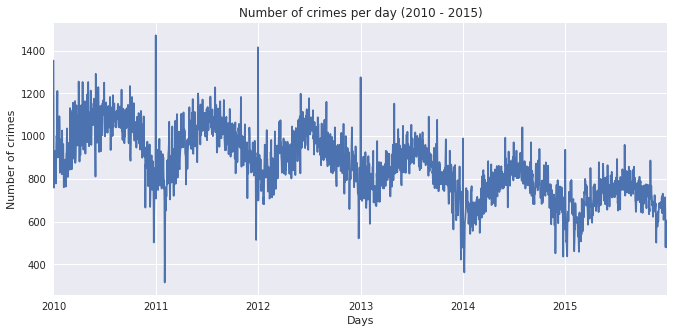

In [37]:
plt.figure(figsize=(11,5))
data.resample('D').size().plot(legend=False)
plt.title('Number of crimes per day (2010 - 2015)')
plt.xlabel('Days')
plt.ylabel('Number of crimes')
plt.show()

We can see a similar trend each year when considering crimes per day. <br>
First crime rates start to increase, than decrease <br>
Overall trend is again downwards

### Week of month

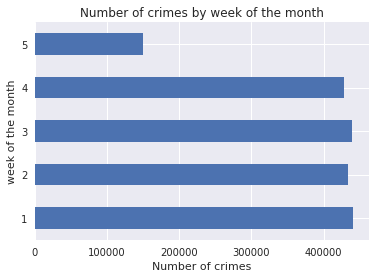

In [38]:
data.groupby([data.weekOfMonth]).size().plot(kind='barh')
plt.ylabel('week of the month')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by week of the month')
plt.show()

In [39]:
data.weekOfMonth.value_counts(normalize=True)

1    0.233084
3    0.232231
2    0.229145
4    0.226019
5    0.079521
Name: weekOfMonth, dtype: float64

Our suspicion was correct! <br>
Last week of the month has considerable low crime rates!

### Week of year

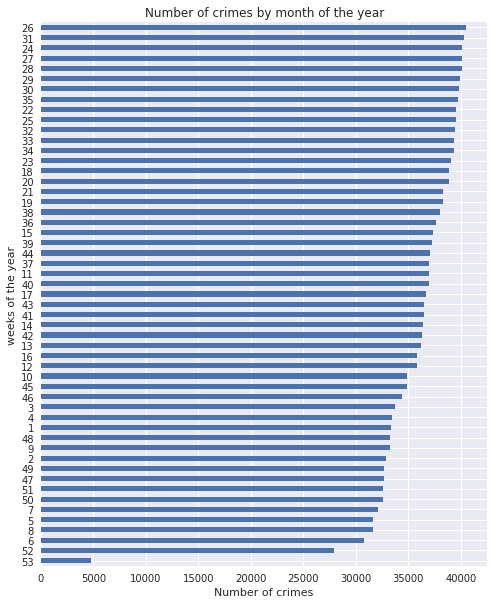

In [40]:
plt.figure(figsize=(8,10))
data.groupby([data.weekOfYear]).size().sort_values().plot(kind='barh')
plt.ylabel('weeks of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

With the exception of week 53(bcoz it has fewest datapoints), crime is lower is end of year

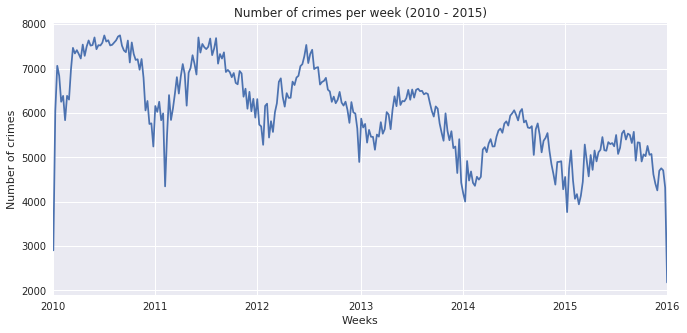

In [41]:
plt.figure(figsize=(11,5))
data.resample('W').size().plot(legend=False)
plt.title('Number of crimes per week (2010 - 2015)')
plt.xlabel('Weeks')
plt.ylabel('Number of crimes')
plt.show()

### Week of Year per district

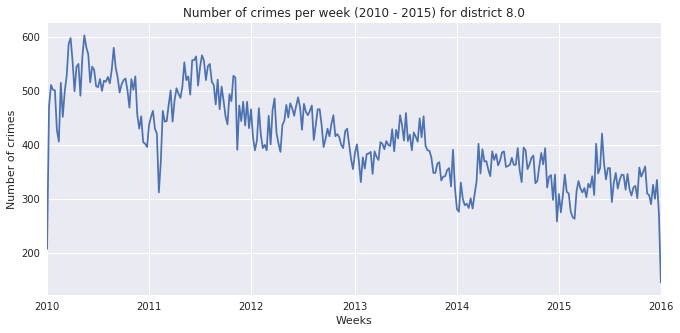

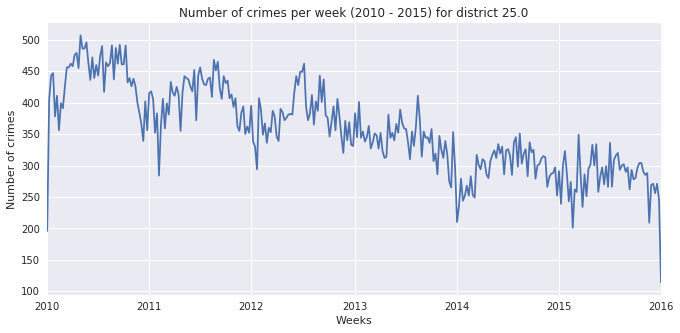

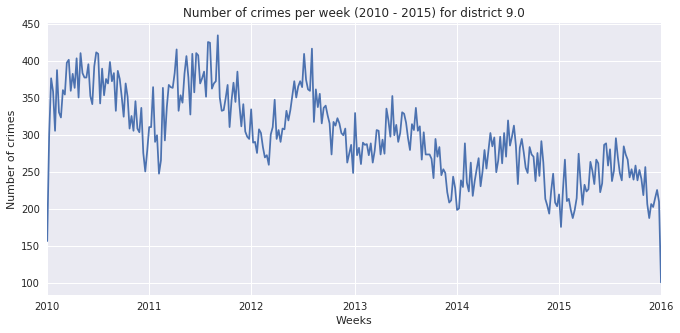

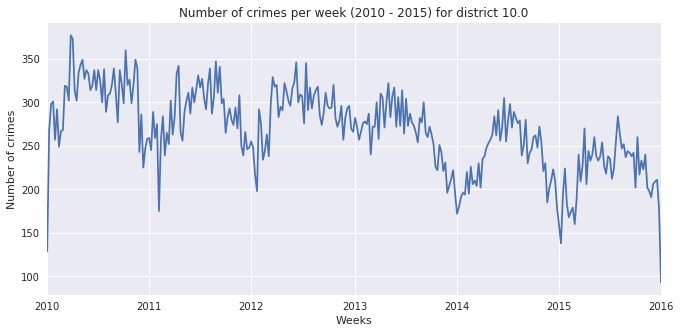

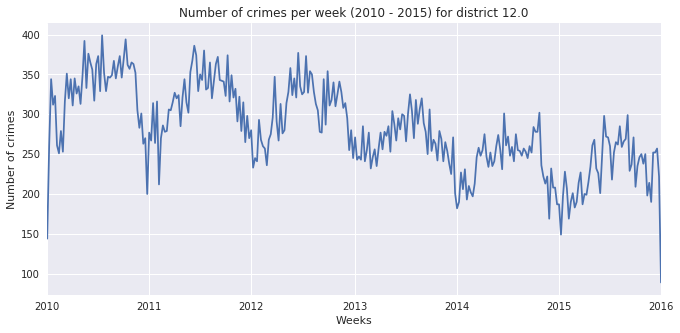

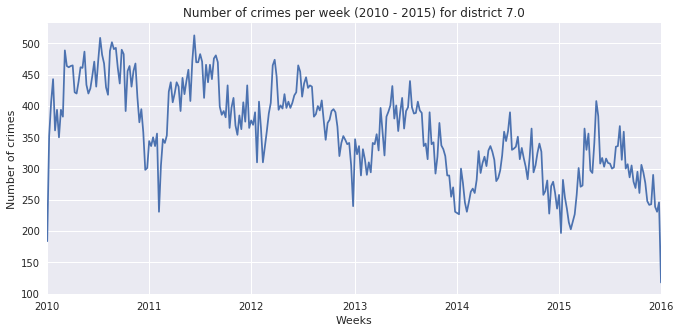

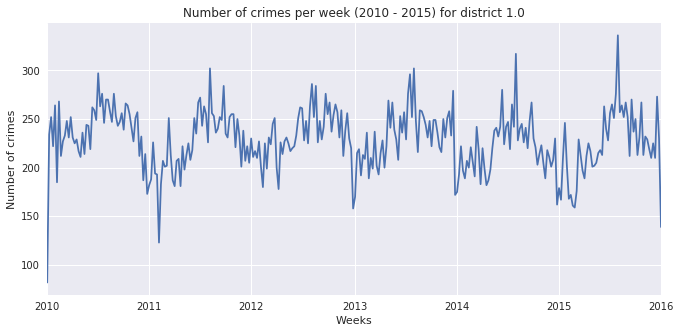

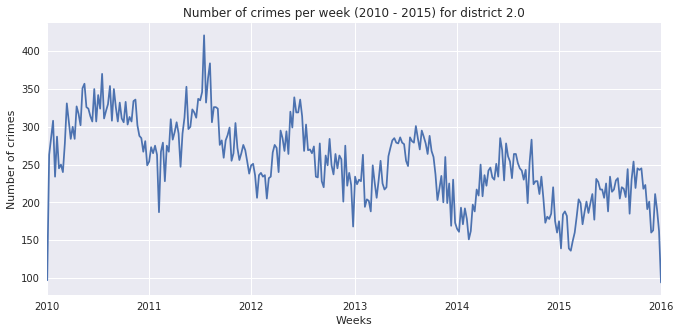

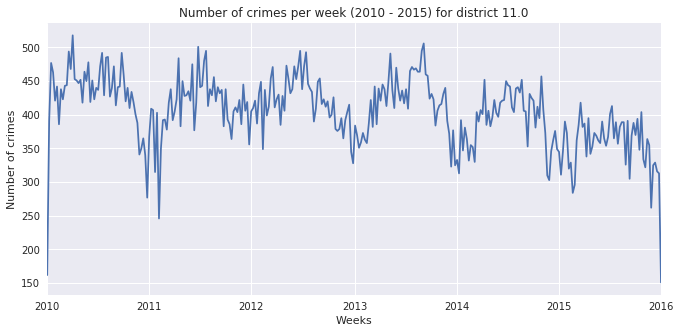

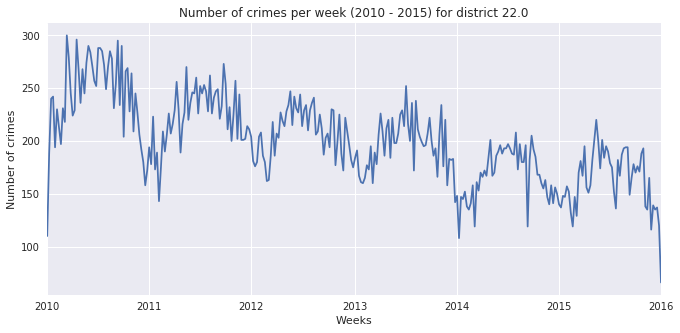

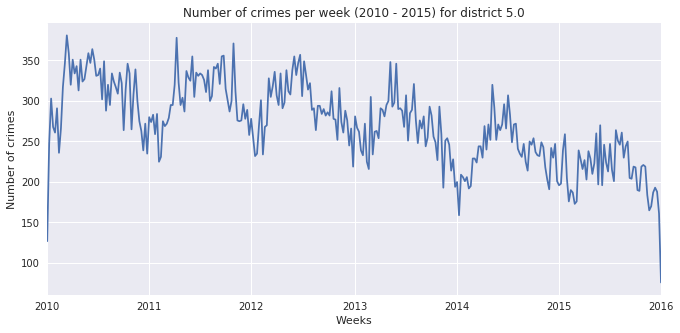

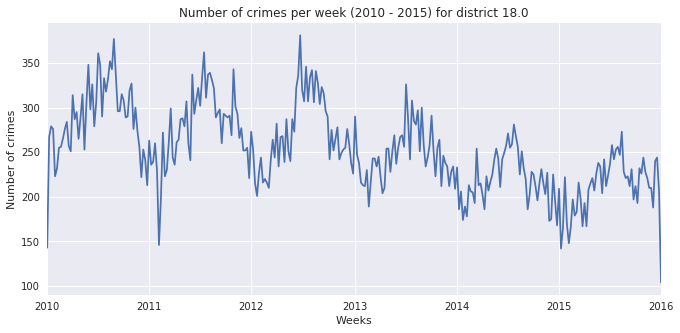

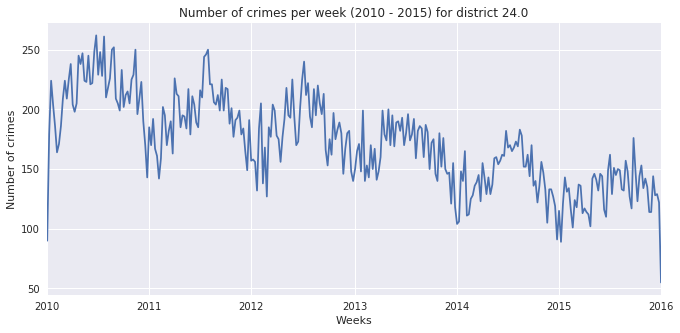

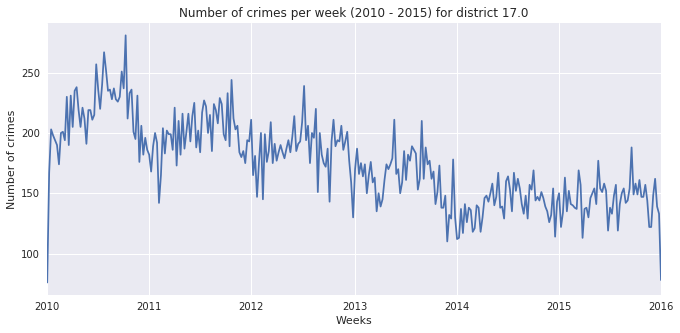

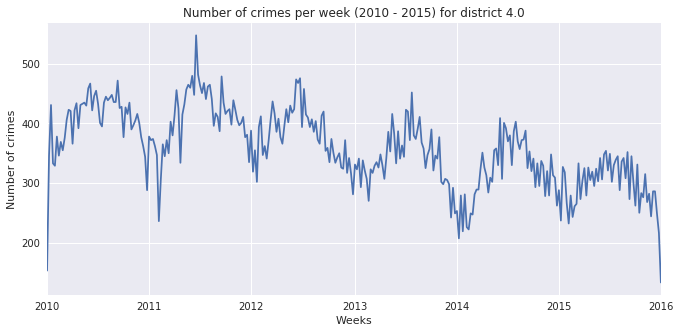

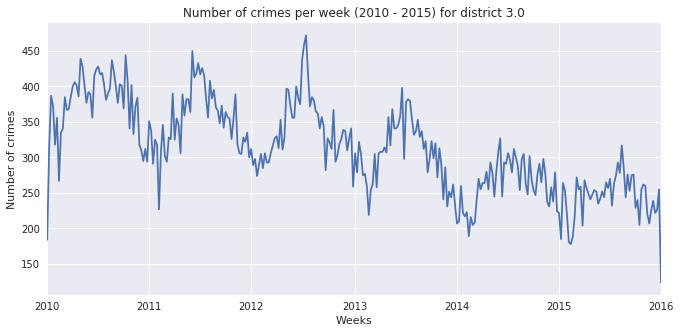

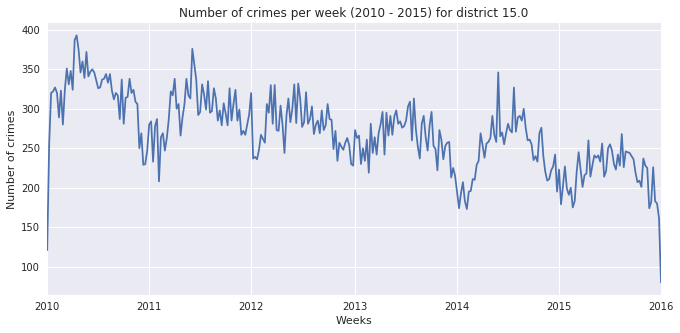

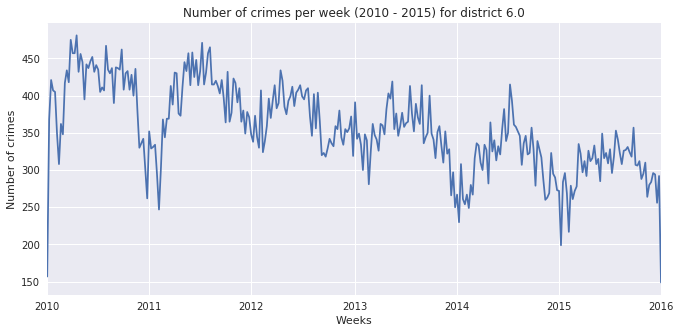

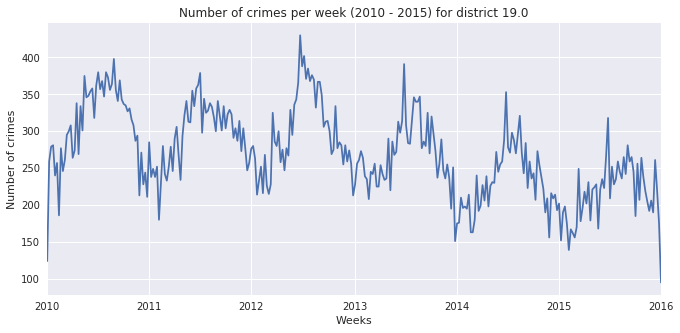

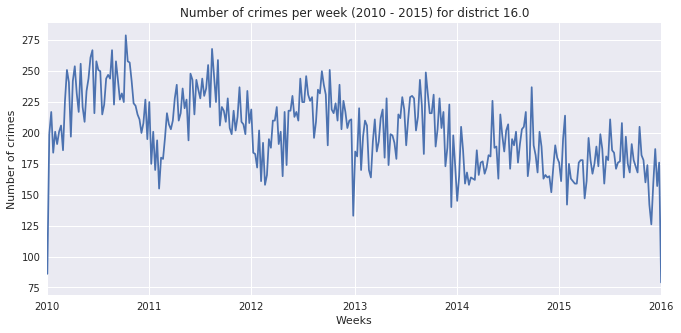

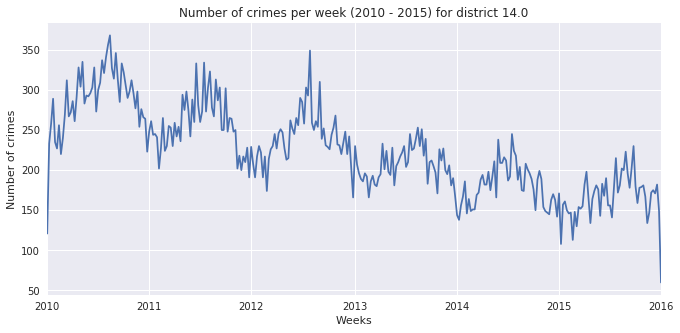

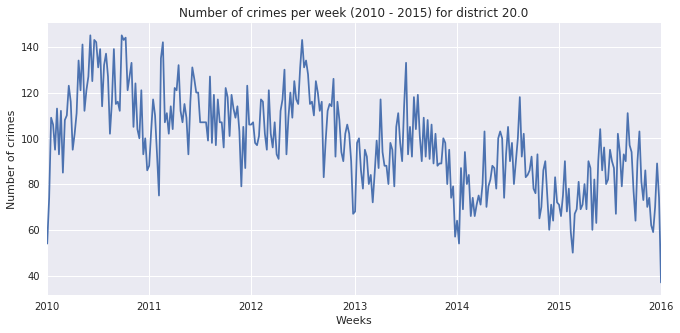

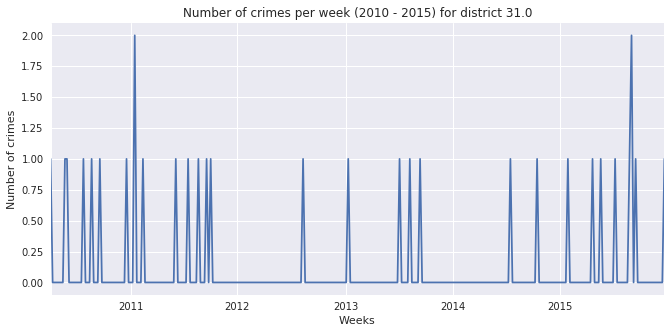

In [42]:
listOfDistricts = list(data['District'].unique())

for district in listOfDistricts:
    df = data[data['District'] == district]
    plt.figure(figsize=(11,5))
    df.resample('W').size().plot(legend=False)
    plt.title('Number of crimes per week (2010 - 2015) for district {}'.format(district))
    plt.xlabel('Weeks')
    plt.ylabel('Number of crimes')
    plt.show()

- Except district 31, we see more or less the same trend in each district.
- The trend is, first the crime per week increases at the start of year and than decreases towards the end of year.

### Year

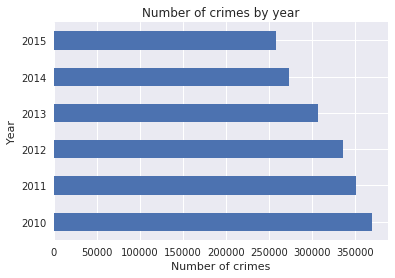

In [43]:
data.groupby([data.Year]).size().plot(kind='barh')
plt.ylabel('Year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by year')
plt.show()

In [44]:
data.Year.value_counts(normalize=True)

2010    0.195304
2011    0.185316
2012    0.176974
2013    0.161775
2014    0.144494
2015    0.136136
Name: Year, dtype: float64

We see crime rates decreasing every year which is a good sign for a city

Findings till now:
- Fourier features can be useful
- Crime has decreased over the years in Chicago
- Last week of month has lowest crimes, good differentiator

### Primary type

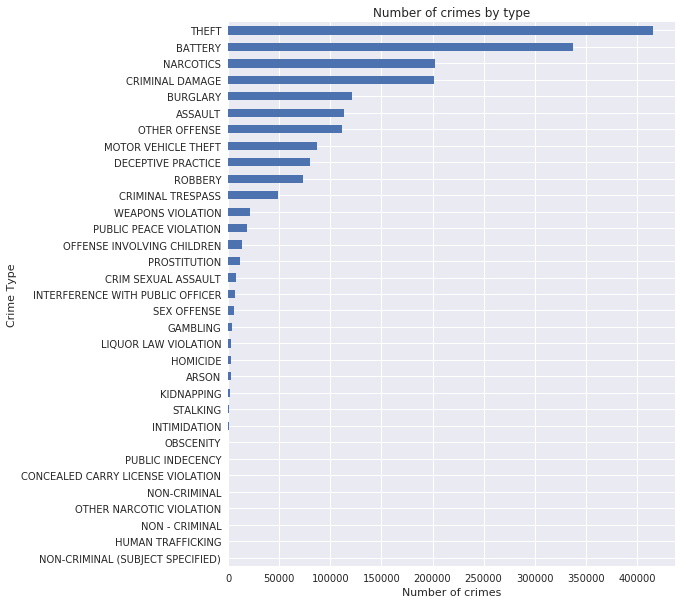

In [45]:
plt.figure(figsize=(8,10))
data.groupby([data['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

In [46]:
data['Primary Type'].value_counts(normalize=True)

THEFT                                0.219793
BATTERY                              0.178061
NARCOTICS                            0.106704
CRIMINAL DAMAGE                      0.106146
BURGLARY                             0.064108
ASSAULT                              0.060025
OTHER OFFENSE                        0.059058
MOTOR VEHICLE THEFT                  0.046139
DECEPTIVE PRACTICE                   0.042260
ROBBERY                              0.038538
CRIMINAL TRESPASS                    0.025521
WEAPONS VIOLATION                    0.011183
PUBLIC PEACE VIOLATION               0.009552
OFFENSE INVOLVING CHILDREN           0.007172
PROSTITUTION                         0.006184
CRIM SEXUAL ASSAULT                  0.004203
INTERFERENCE WITH PUBLIC OFFICER     0.003727
SEX OFFENSE                          0.003152
GAMBLING                             0.001947
LIQUOR LAW VIOLATION                 0.001626
HOMICIDE                             0.001451
ARSON                             

- There are 33 different types of Primary types of Crime
- Primary type is Level 1 category of the crime
- seeing from the graph and counts we can see that few categories like OBSCENITY and below have very less crime numbers and can be removed from the data (deemed as outliers)

In [47]:
print('Current rows:', data.shape[0])
data['Primary Type'] = data['Primary Type'].astype(str)
data = data[(data['Primary Type'] != 'OBSCENITY') & 
            (data['Primary Type'] != 'PUBLIC INDECENCY') & 
            (data['Primary Type'] != 'CONCEALED CARRY LICENSE VIOLATION') & 
            (data['Primary Type'] != 'NON-CRIMINAL') & 
            (data['Primary Type'] != 'OTHER NARCOTIC VIOLATION') & 
            (data['Primary Type'] != 'NON - CRIMINAL') & 
            (data['Primary Type'] != 'HUMAN TRAFFICKING') & 
            (data['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)')]

print('Rows after removing primary type outliers:', data.shape[0])

Current rows: 1893314
Rows after removing primary type outliers: 1892863


Few hundred rows are removed and as this is a categorical feature, complexity of the problem is also reduced

### Location Descrption

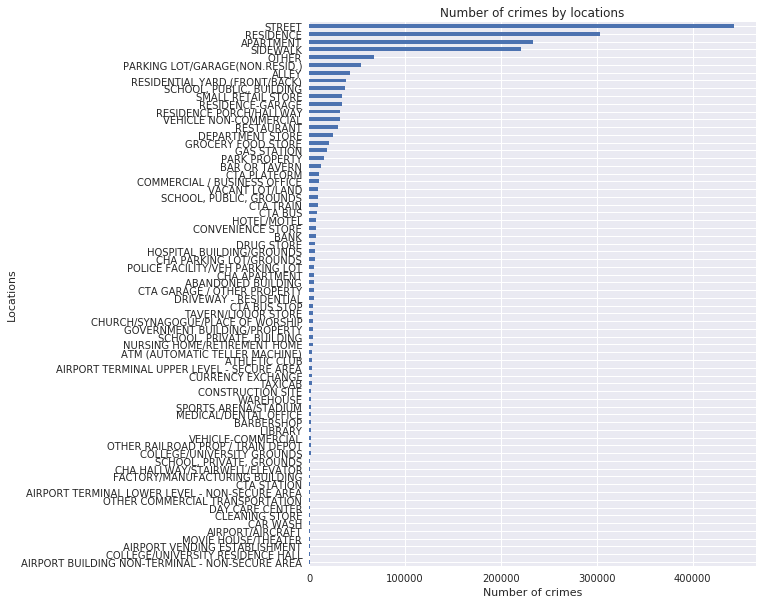

In [48]:
plt.figure(figsize=(8,10))
data.groupby([data['Location Description']]).size().sort_values(ascending=True)[-70:].plot(kind='barh')
plt.title('Number of crimes by locations')
plt.ylabel('Locations')
plt.xlabel('Number of crimes')
plt.show()

We'll only keep crimes in top 50 locations

In [49]:
top50Locations = list(data.groupby([data['Location Description']]).size().sort_values(ascending=True)[-50:].index)

In [50]:
print('Current rows:', data.shape[0])
data = data[data['Location Description'].isin(top50Locations)]
print('Rows after removing location outliers:', data.shape[0])

Current rows: 1892863
Rows after removing location outliers: 1862906


Removed some 30K rows

In [51]:
data['Location Description'].value_counts()

STREET                                        443643
RESIDENCE                                     303384
APARTMENT                                     233711
SIDEWALK                                      221461
OTHER                                          67972
PARKING LOT/GARAGE(NON.RESID.)                 53994
ALLEY                                          42320
RESIDENTIAL YARD (FRONT/BACK)                  38040
SCHOOL, PUBLIC, BUILDING                       36950
SMALL RETAIL STORE                             34726
RESIDENCE-GARAGE                               34696
RESIDENCE PORCH/HALLWAY                        32610
VEHICLE NON-COMMERCIAL                         31876
RESTAURANT                                     30079
DEPARTMENT STORE                               24959
GROCERY FOOD STORE                             20333
GAS STATION                                    18828
PARK PROPERTY                                  15822
BAR OR TAVERN                                 

### Description

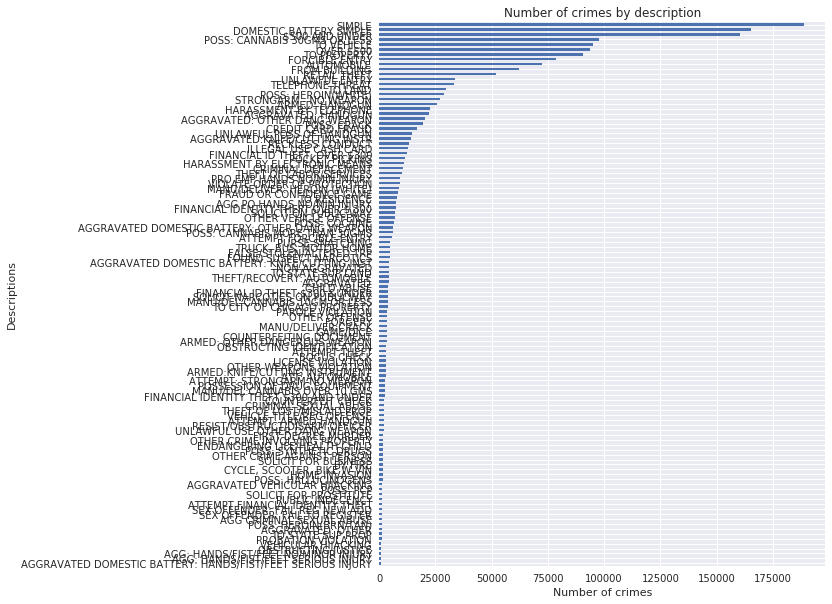

In [52]:
plt.figure(figsize=(8,10))
data.groupby([data['Description']]).size().sort_values(ascending=True)[-110:].plot(kind='barh')
plt.title('Number of crimes by description')
plt.ylabel('Descriptions')
plt.xlabel('Number of crimes')
plt.show()

We'll keep crimes with top 100 descriptions only

In [53]:
top100Desc = list(data.groupby([data['Description']]).size().sort_values(ascending=True)[-100:].index)

In [54]:
print('Current rows:', data.shape[0])
data = data[data['Description'].isin(top100Desc)]
print('Rows after removing description outliers:', data.shape[0])

Current rows: 1862906
Rows after removing description outliers: 1806498


Removed some 60K rows

In [55]:
data['Description'].value_counts()

SIMPLE                                     188939
DOMESTIC BATTERY SIMPLE                    165348
$500 AND UNDER                             160494
POSS: CANNABIS 30GMS OR LESS                97923
TO VEHICLE                                  95234
OVER $500                                   93856
TO PROPERTY                                 90459
FORCIBLE ENTRY                              78732
AUTOMOBILE                                  72361
FROM BUILDING                               62001
RETAIL THEFT                                51991
UNLAWFUL ENTRY                              33791
TELEPHONE THREAT                            33120
TO LAND                                     29701
POSS: HEROIN(WHITE)                         28883
STRONGARM - NO WEAPON                       27219
ARMED: HANDGUN                              25536
HARASSMENT BY TELEPHONE                     22623
AGGRAVATED: HANDGUN                         22374
AGGRAVATED: OTHER DANG WEAPON               20558


### Latitude and Longitude

In [56]:
map_osm = folium.Map(location=[41.881832, -87.623177], tiles='Stamen Toner')
samplePoints = data.sample(n = 100, random_state = 42)
for i,j in samplePoints.iterrows():
    folium.Marker(list((j['Latitude'],j['Longitude']))).add_to(map_osm)

In [57]:
map_osm

Displaying some sample points where crimes have happened

### District

Text(0.5, 1.0, 'All Crime Distribution per District')

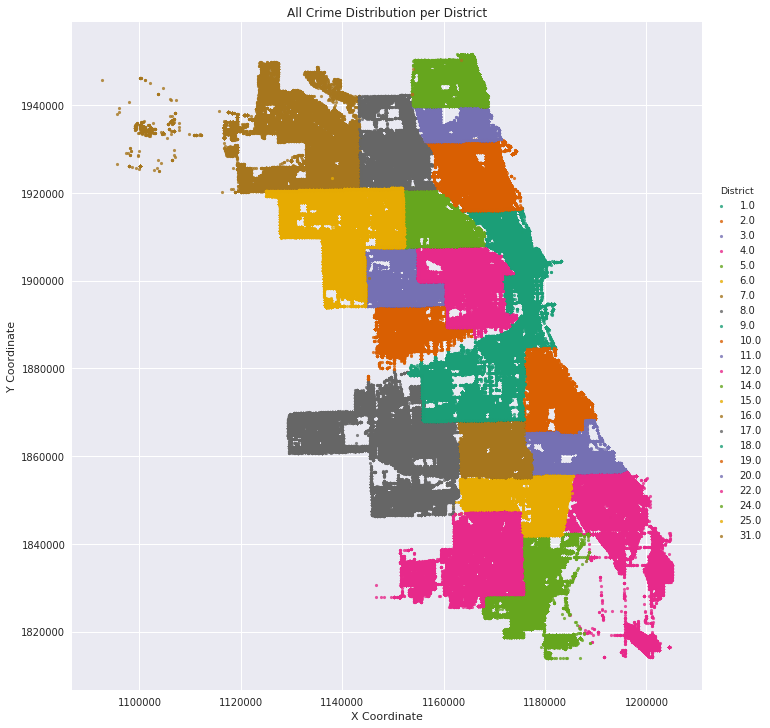

In [58]:
sns.lmplot('X Coordinate', 
           'Y Coordinate',
           data=data[:],
           fit_reg=False, 
           hue="District",
           palette='Dark2',
           height=10,
           ci=2,
           scatter_kws={"marker": "D", 
                        "s": 10})
ax = plt.gca()
ax.set_title("All Crime Distribution per District")

From the graph above we can see that we don't have crimes in district 21,23,26,27,28,29,30
Reason for this:
- These district numbers are not used

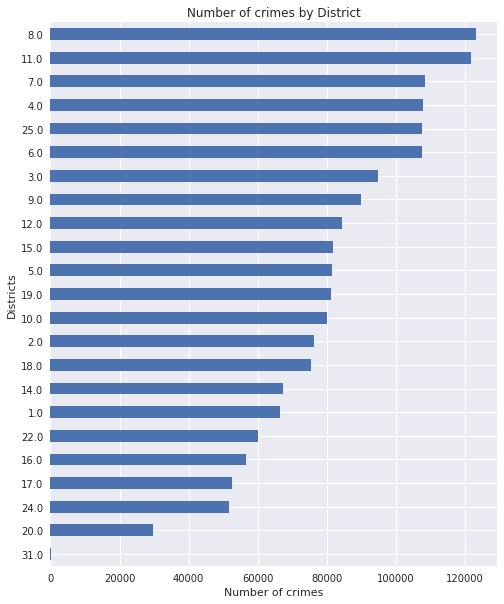

In [59]:
plt.figure(figsize=(8,10))
data.groupby([data['District']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by District')
plt.ylabel('Districts')
plt.xlabel('Number of crimes')
plt.show()

There are 31 different districts

District number 31 has almost no crimes. Crime free district?

In [60]:
data[data['District'] == 31.0].shape[0]

21

District number 31 is very safe as opposed to other districts with only 21 counts of crimes in 6 years!

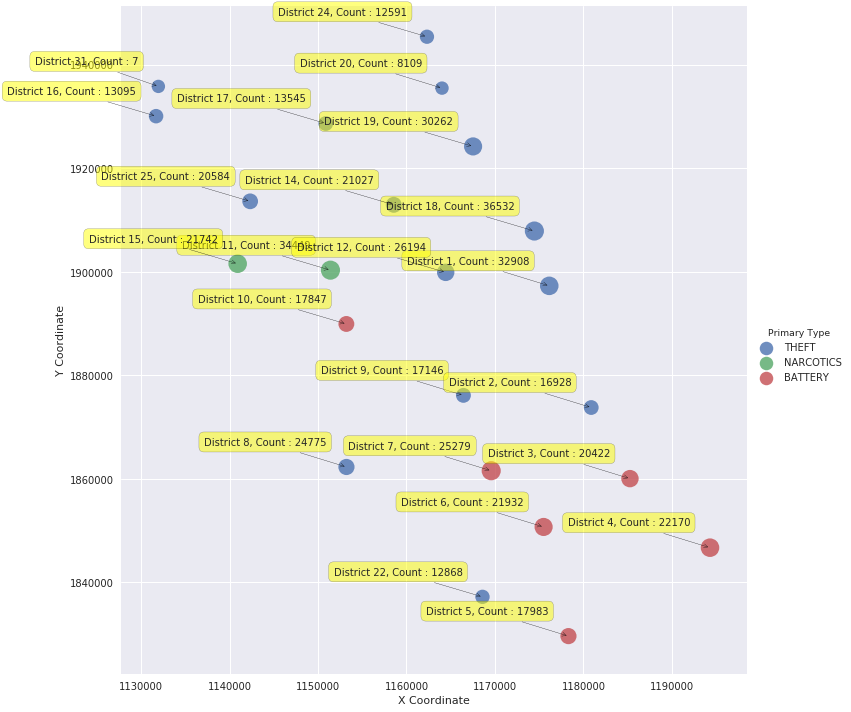

In [61]:
sdf = data.groupby(['District', 'Primary Type']).size().reset_index(name='counts')
idx = sdf.groupby(['District'])['counts'].transform(max) == sdf['counts']
sdf = sdf[idx]
other = data.groupby('District')[['X Coordinate', 'Y Coordinate']].mean()

sdf = sdf.set_index('District').join(other)
sdf = sdf.reset_index().sort_values("counts",ascending=False)
sns.lmplot(x='X Coordinate', y='Y Coordinate',height=10, hue='Primary Type', data=sdf,scatter_kws={"s": sdf['counts'].apply(lambda x: x/100.0)}, fit_reg=False)

for r in sdf.reset_index().as_matrix():

    district = "District {0}, Count : {1}".format(int(r[1]),int(r[3]))
    x = r[4]
    y = r[5]
    plt.annotate(
        district,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

- Battery crimes are mainly in south Chicago
- Narcotics crimes are in a cluster of districts only around north chicago

In [62]:
#ignoring 31st district for now bcoz it had least crimes
data = data[data['District'] != 31.0] #after this we'll have 22 distritcs

### Community Area

Text(0.5, 1.0, 'All Crime Distribution per Community Area')

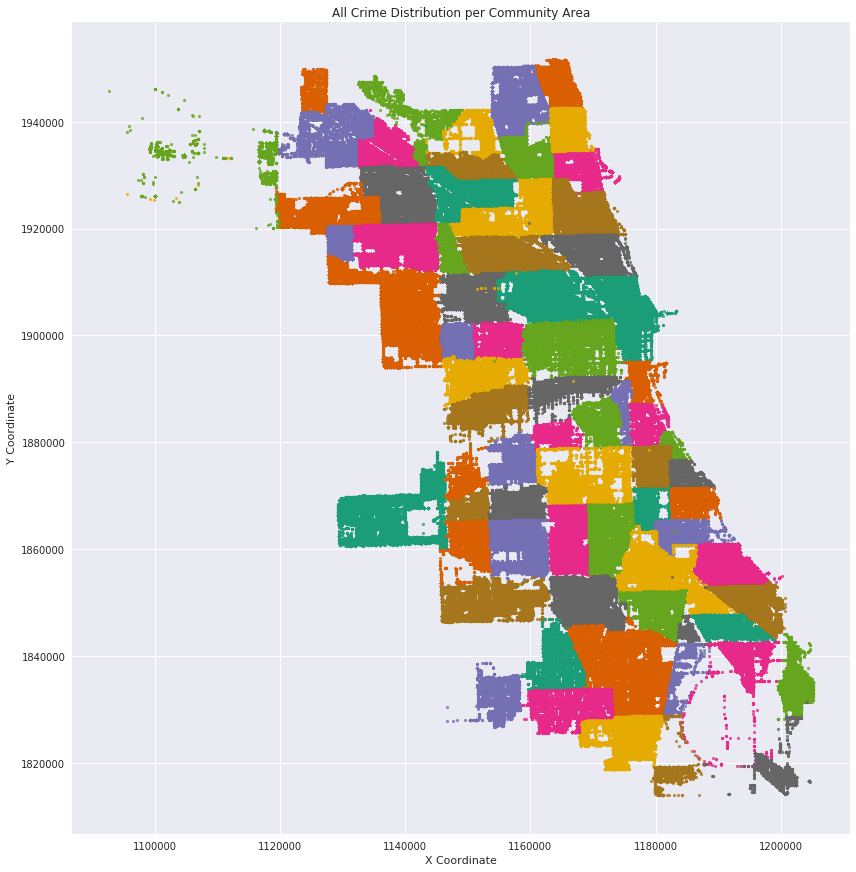

In [63]:
sns.lmplot('X Coordinate', 
           'Y Coordinate',
           data=data[:],
           fit_reg=False, 
           hue="Community Area",
           palette='Dark2',
           legend=False,
           height=12,
           ci=2,
           scatter_kws={"marker": "D", 
                        "s": 10})
ax = plt.gca()
ax.set_title("All Crime Distribution per Community Area")

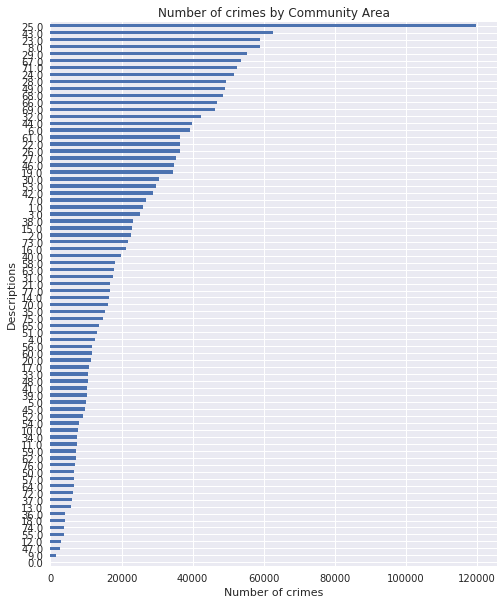

In [64]:
plt.figure(figsize=(8,10))
data.groupby([data['Community Area']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Community Area')
plt.ylabel('Descriptions')
plt.xlabel('Number of crimes')
plt.show()

- There are 77 different community areas
- each community area is represented with a different color
- Community Area number 25 has very high crime rate
- There is an errorneous community area 0.0 (community areas should be from 1-77). We'll remove these rows

In [65]:
print('Current rows:', data.shape[0])
data = data[data['Community Area'] != 0.0]
print('Rows after removing description outliers:', data.shape[0])

Current rows: 1806477
Rows after removing description outliers: 1806469


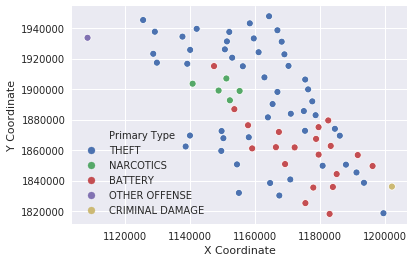

In [66]:
sdf = data.groupby(['Community Area', 'Primary Type']).size().reset_index(name='counts')
idx = sdf.groupby(['Community Area'])['counts'].transform(max) == sdf['counts']
sdf = sdf[idx]
other = data.groupby('Community Area')[['X Coordinate', 'Y Coordinate']].mean()

sdf = sdf.set_index('Community Area').join(other)
sdf = sdf.reset_index().sort_values("counts",ascending=False)
sns.scatterplot(x='X Coordinate', y='Y Coordinate', hue='Primary Type', data=sdf)

- Communities show a similar trend as district
- A lot of Southern communities have battery crimes
- some communities on border have narcotics crimes

### Arrest & Domestic

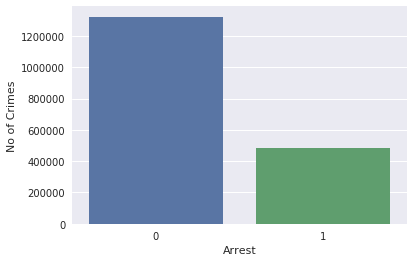

In [67]:
sns.countplot(x='Arrest',data=data)
plt.ylabel('No of Crimes')
plt.show()

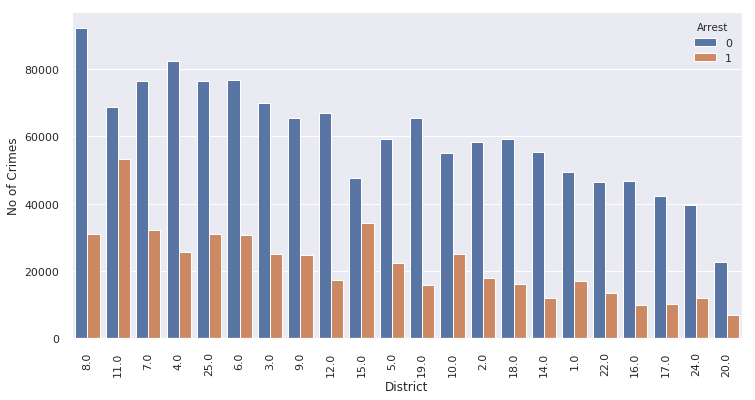

In [68]:
sns.set(rc={'figure.figsize':(12,6)})
sns.countplot(x='District',hue='Arrest',data=data,order=data['District'].value_counts().index)
plt.xticks(rotation='vertical')
plt.ylabel('No of Crimes')
plt.show()

- Not much information gathered from here.
- Most crimes are of no arrests

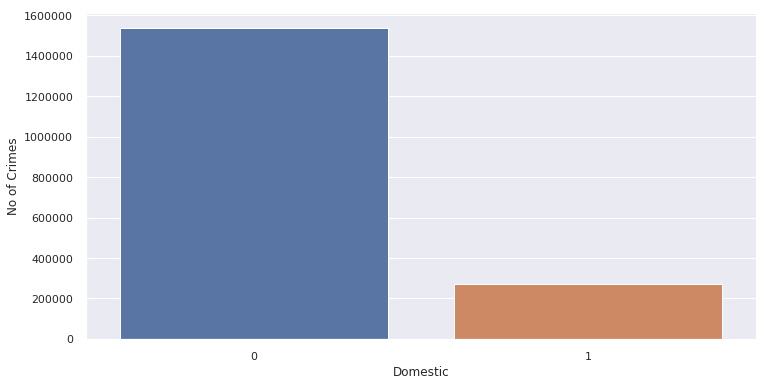

In [69]:
sns.countplot(x='Domestic',data=data)
plt.ylabel('No of Crimes')
plt.show()

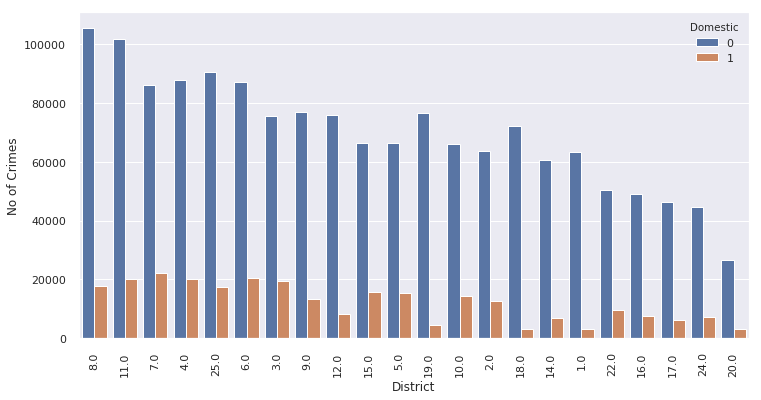

In [70]:
sns.set(rc={'figure.figsize':(12,6)})
sns.countplot(x='District',hue='Domestic',data=data,order=data['District'].value_counts().index)
plt.xticks(rotation='vertical')
plt.ylabel('No of Crimes')
plt.show()

- Most crimes are not domestic related
- Districts like 1,18,19 have very few domestic crimes

In [71]:
data.to_csv('data-clean.csv', index_label=False)

### Plotting Heatmaps

Let's consider the 2015 crimes (from Jan-Mar) happening in day or night time for different communities and plot a heat map <br>
Credits: <br>
https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf <br>
https://python-visualization.github.io/folium/ <br>
https://www.kaggle.com/fahd09/eda-of-crime-in-chicago-2005-2016

In [7]:
"""
This function generates a folium map with Chicago location and given zoom value.
"""

def generateBaseMap(default_location=[41.8781, -87.6298], default_zoom_start=10):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [5]:
data = pd.read_csv('data/data-clean.csv')
data.index = pd.DatetimeIndex(data.Date)

data['hour'] = data.index.hour
data['dayType'] = data['hour'].apply(lambda x: 'Day' if (x >= 6 and x < 18) else 'Night')

data_2015 = data.loc['2015-01-01':'2015-03-31']

In [6]:
data_2015_day = data_2015[data_2015['dayType'] == 'Day']

In [8]:
base_map = generateBaseMap()
HeatMap(data=data_2015_day[['Latitude', 'Longitude']].\
        groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

base_map

In [9]:
data_2015_night = data_2015[data_2015['dayType'] == 'Night']

base_map1 = generateBaseMap()
HeatMap(data=data_2015_night[['Latitude', 'Longitude']].\
        groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map1)

base_map1

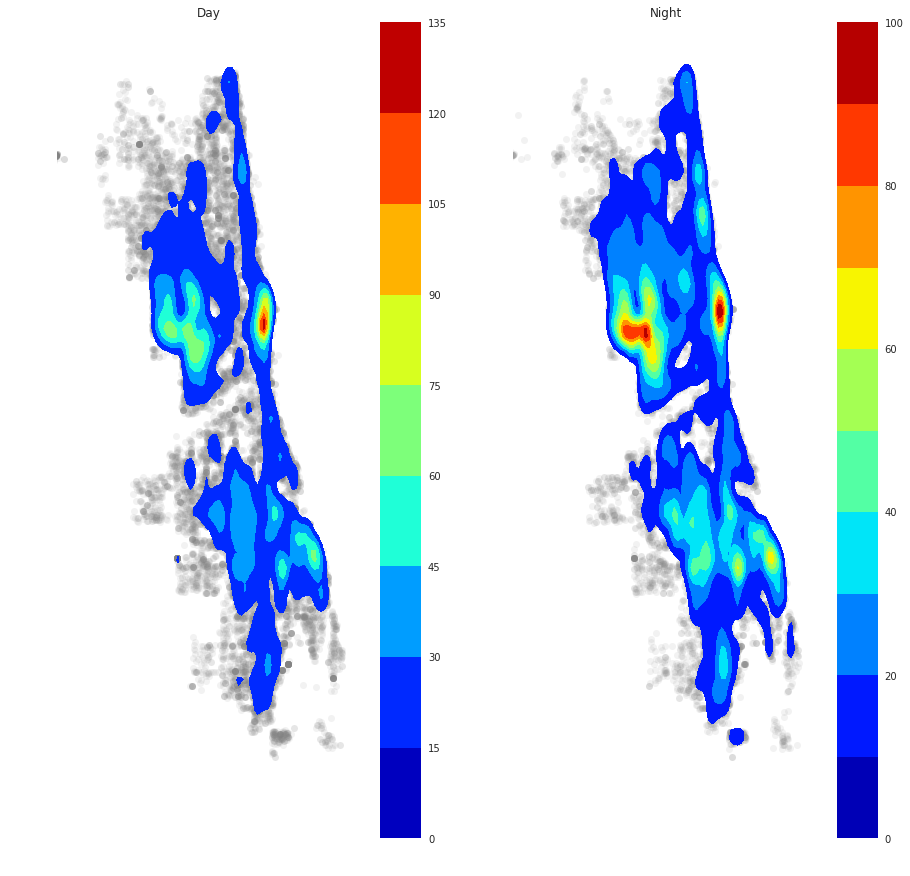

In [10]:
ctypes = ['Day', 'Night']

fig = plt.figure(figsize=(15,15))
for i, crime_type in enumerate(ctypes):
    ax = fig.add_subplot(int(np.ceil(float(len(ctypes)) / 2)), 2, i+1)
    crimes_ = data_2015[data_2015['dayType']==crime_type]
    sns.regplot('Longitude', 'Latitude',
               data= crimes_[['Longitude','Latitude']],
               fit_reg=False,
               scatter_kws={'alpha':.1, 'color':'grey'},
               ax=ax)
    sns.kdeplot(X='Longitude', Y='Latitude',
                data= crimes_[['Longitude','Latitude']],
                cmap="jet", 
                bw=.005,
                #n_levels=10,
                cbar=True, 
                shade=True, 
                shade_lowest=False,
                ax = ax)
    ax.set_title(crime_type)
    ax.set_xlim(-87.9,-87.5)
    ax.set_ylim(41.60,42.05)
    ax.set_axis_off()    
plt.show()

We have plotted hatmaps for crimes happening in day and night in the city of Chicago using Folium library and kde plots of seaborn. <br>
We can observe that more crimes happen at night in comparision to day time!